# Course Recommender: Collaborative-Filtering Methods with Neural Networks

This project implements and deploys an AI course Recommender System using [Streamlit](https://streamlit.io/). It was inspired by the the [IBM Machine Learning Professional Certificate](https://www.coursera.org/professional-certificates/ibm-machine-learning) offered by IBM & Coursera. In the last course/module of the Specialization, Machine Learning Capstone, a similar application is built; check my [class notes](https://github.com/mxagar/machine_learning_ibm/tree/main/06_Capstone_Project/06_Capstone_Recommender_System.md) for more information.

This notebook researches and implements different **Collaborative-Filtering** recommender systems based on Artificial Neural Networks (ANN). You can open it in Google Colab:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mxagar/course_recommender_streamlit/blob/main/notebooks/05_Collaborative_RecSys_ANN.ipynb)

The following is implemented in the current notebook:

  - A very simple ANN is created with Keras using OOP, i.e., inheriting the `tensorflow.keras.Model` class. The model takes the dense ratings dataframe encoded with indices and it builds two embeddings: one for the user representations and the other for the item representations. Both embeddings have size 16 and are multiplied (dot product) to predict the rating.
  - The training results in two important embedding matrices, which encode latent features. Therefore, we have the following dataframes:
    - user embeddings: `(33901, 17)`
    - item embeddings: `(126, 17)`
    - ratings (dense): `(233306, 3)`
  - The embeddings are joined to the ratings dataframe so that we get a table of shape `(233306, 3+16+16)`. Then, the two embedding vectors are summed and we collapse the large dataframe to a shape of `(233306, 16+1)`, i.e., 16 features (summed embedding vectors) and the rating (target).
  - With this dataset, regression models are applied:
    - Linear regression.
    - Lasso regression with cross-validation.
    - Ridge regression with cross-validation.
    - Random forest classifier with a grid search.

![Embedding feature vectors](../assets/embedding_feature_vector.jpg)

![Embedding feature vectors - regression](../assets/rating_regression.jpg)

Table of contents:

- [Part 1: Create the Embedding Features](#Part-1:-Create-the-Embedding-Features)
  - [1. Load Dataset](#1.-Load-Dataset)
  - [2. Define and Train Neural Network to Extract Embeddings](#2.-Define-and-Train-Neural-Network-to-Extract-Embeddings)
  - [3. Extract and Persist Embeddings](#3.-Extract-and-Persist-Embeddings)
- [Part 2: Regression and Classification Models of the Embeddings](#Part-2:-Regression-and-Classification-Models-of-the-Embeddings)
  - [1. Prepare Dataset](#1.-Prepare-Dataset)
  - [2. Perform Regression](#2.-Perform-Regression)
    - Linear Regression
    - Regularized Regression with Cross-Validation: Lasso, Ridge
  - [3. Perform Classification](#3.-Perform-Classification)
    - Random Forest Classifier

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

In [6]:
# Set a random state
rs = 123

# Part 1: Create the Embedding Features

## 1. Load Dataset

In [3]:
rating_df = pd.read_csv("../data/ratings.csv")
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


In [4]:
rating_df.shape

(233306, 3)

In [5]:
num_users = len(rating_df['user'].unique())
num_items = len(rating_df['item'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `33901` of users and `126` items


## 2. Define and Train Neural Network to Extract Embeddings

In [7]:
class RecommenderNet(keras.Model):
    
    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        
        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")
        
        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")
        
    def call(self, inputs):
        """
           method to be called during model fitting
           
           :param inputs: user and item one-hot vectors
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # Sigmoid output layer to output the probability
        return tf.nn.relu(x)

In [8]:
def process_dataset(raw_data):
    
    encoded_data = raw_data.copy()
    
    # Mapping user ids to indices
    user_list = encoded_data["user"].unique().tolist()
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)}
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)}
    
    # Mapping course ids to indices
    course_list = encoded_data["item"].unique().tolist()
    course_id2idx_dict = {x: i for i, x in enumerate(course_list)}
    course_idx2id_dict = {i: x for i, x in enumerate(course_list)}

    # Convert original user ids to idx
    encoded_data["user"] = encoded_data["user"].map(user_id2idx_dict)
    # Convert original course ids to idx
    encoded_data["item"] = encoded_data["item"].map(course_id2idx_dict)
    # Convert rating to int
    encoded_data["rating"] = encoded_data["rating"].values.astype("int")

    return encoded_data, user_idx2id_dict, course_idx2id_dict

In [9]:
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(rating_df)

In [10]:
encoded_data.head()

,user,item,rating
0,0,0,3
1,1,1,3
2,2,2,3
3,3,3,3
4,4,4,3


In [11]:
def generate_train_test_datasets(dataset, scale=True):

    min_rating = min(dataset["rating"])
    max_rating = max(dataset["rating"])

    dataset = dataset.sample(frac=1, random_state=42)
    x = dataset[["user", "item"]].values
    if scale:
        y = dataset["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    else:
        y = dataset["rating"].values

    # Assuming training on 80% of the data and validating on 10%, and testing 10%
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])

    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices],
        x[train_indices:test_indices],
        x[test_indices:],
        y[:train_indices],
        y[train_indices:test_indices],
        y[test_indices:],
    )
    return x_train, x_val, x_test, y_train, y_val, y_test

In [12]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)

In [13]:
x_train.shape # user, course

(186644, 2)

In [14]:
user_indices = x_train[:, 0]
user_indices

array([ 8376,  7659, 10717, ...,  3409, 28761,  4973])

In [15]:
item_indices = x_train[:, 1]
item_indices

array([12, 29,  3, ..., 18, 19, 17])

In [16]:
embedding_size = 16
model = RecommenderNet(num_users, num_items, embedding_size)

In [17]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError

model.compile(optimizer=Adam(lr = .003),
                loss=MeanSquaredError(), 
                metric=RootMeanSquaredError())

run_hist = model.fit(x_train,
                         y_train,
                         validation_data=(x_test, y_test),
                         epochs=5,
                         shuffle=True)

2023-02-04 09:02:32.623812: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 09:02:32.626397: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Train on 186644 samples, validate on 23331 samples
Epoch 1/5


/Users/mxagar/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/mxagar/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


186644/186644 [==============================] - 55s 295us/sample - loss: 0.0832 - val_loss: 0.0553
Epoch 2/5
186644/186644 [==============================] - 53s 286us/sample - loss: 0.0649 - val_loss: 0.0781
Epoch 3/5
186644/186644 [==============================] - 54s 289us/sample - loss: 0.0839 - val_loss: 0.0934
Epoch 4/5
186644/186644 [==============================] - 54s 290us/sample - loss: 0.0952 - val_loss: 0.1060
Epoch 5/5
186644/186644 [==============================] - 62s 330us/sample - loss: 0.1090 - val_loss: 0.1228


In [18]:
run_hist.history.keys()

dict_keys(['loss', 'val_loss'])

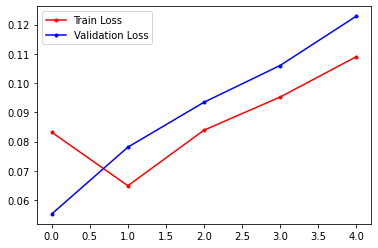

In [19]:
fig, ax = plt.subplots()
ax.plot(run_hist.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

In [20]:
model.evaluate(x_test,y_test,verbose=0)

0.12282953584033171

## 3. Extract and Persist Embeddings

In [21]:
model.summary()

Model: "recommender_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
user_embedding_layer (Embedd multiple                  542416    
_________________________________________________________________
user_bias (Embedding)        multiple                  33901     
_________________________________________________________________
item_embedding_layer (Embedd multiple                  2016      
_________________________________________________________________
item_bias (Embedding)        multiple                  126       
Total params: 578,459
Trainable params: 578,459
Non-trainable params: 0
_________________________________________________________________


In [22]:
# User features
user_latent_features = model.get_layer('user_embedding_layer').get_weights()[0]
print(f"User features shape: {user_latent_features.shape}")

User features shape: (33901, 16)


In [23]:
user_latent_features[0]

array([ 0.03736337,  0.39427406, -0.04172319,  0.20165065, -0.11913025,
       -0.25450367,  0.20215334,  0.23786804,  0.08437391,  0.01716124,
       -0.20202145, -0.46880993, -0.19820866, -0.04530432, -0.4169354 ,
       -0.3730686 ], dtype=float32)

In [25]:
# Course/item features
item_latent_features = model.get_layer('item_embedding_layer').get_weights()[0]
print(f"Item features shape: {item_latent_features.shape}")

Item features shape: (126, 16)


In [26]:
item_latent_features[0]

array([ 0.00017854, -0.06646857, -0.03985178,  0.07657506,  0.00426503,
        0.02875166,  0.03254846, -0.0100686 , -0.00121374,  0.01292956,
       -0.04164341,  0.07415272, -0.08505473, -0.00319362, -0.13746248,
       -0.0004338 ], dtype=float32)

In [27]:
# Create a dataframe of the user features
user_columns = [f"UFeature{i}" for i in range(user_latent_features.shape[1])]
user_embeddings_df = pd.DataFrame(data=user_latent_features, columns = user_columns)
user_embeddings_df['user'] = user_embeddings_df.index
# Shift column 'user' to first position
first_column = user_embeddings_df.pop('user')
user_embeddings_df.insert(0, 'user', first_column)
# Decode user ids
user_embeddings_df['user'] = user_embeddings_df['user'].replace(user_idx2id_dict)
user_embeddings_df.head()

,user,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,UFeature7,UFeature8,UFeature9,UFeature10,UFeature11,UFeature12,UFeature13,UFeature14,UFeature15
0,1889878,0.037363,0.394274,-0.041723,0.201651,-0.119130,-0.254504,0.202153,0.237868,0.084374,0.017161,-0.202021,-0.468810,-0.198209,-0.045304,-0.416935,-0.373069
1,1342067,0.079197,0.348854,0.201428,-0.094731,-0.078270,0.250712,0.186442,-0.033630,-0.167372,0.274865,-0.153683,-0.142953,-0.086704,0.200799,0.402748,0.317898
2,1990814,0.090707,-0.580528,0.016279,-0.175532,-0.453024,0.157056,-0.060022,0.087126,0.344923,-0.083886,-0.234925,0.262393,-0.372628,-0.197599,0.263074,0.071419
3,380098,-0.247264,-0.022498,0.302606,-0.296971,0.233045,-0.593748,-0.012848,-0.008598,0.085366,-0.358428,0.070679,-0.548603,-0.217238,0.287327,-0.111407,-0.218006
4,779563,0.060767,-0.071871,0.083888,0.165368,0.068353,-0.131535,-0.026316,0.256422,0.246456,-0.191131,0.115227,-0.069518,0.319445,-0.010730,-0.316350,-0.180957


In [28]:
# Presist
user_embeddings_df.to_csv('../data/user_embeddings_computed.csv', sep=',', header=True, index=False)

In [29]:
# Create a dataframe of the item features
item_columns = [f"CFeature{i}" for i in range(item_latent_features.shape[1])]
item_embeddings_df = pd.DataFrame(data=item_latent_features, columns = item_columns)
item_embeddings_df['item'] = item_embeddings_df.index
# Shift column 'item' to first position
first_column = item_embeddings_df.pop('item')
item_embeddings_df.insert(0, 'item', first_column)
# Decode user ids
item_embeddings_df['item'] = item_embeddings_df['item'].replace(course_idx2id_dict)
item_embeddings_df.head()

,item,CFeature0,CFeature1,CFeature2,CFeature3,CFeature4,CFeature5,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,CC0101EN,0.000179,-0.066469,-0.039852,0.076575,0.004265,0.028752,0.032548,-0.010069,-0.001214,0.012930,-0.041643,0.074153,-0.085055,-0.003194,-0.137462,-0.000434
1,CL0101EN,-0.013564,-0.009729,0.009777,0.053337,0.044205,-0.004143,-0.043374,-0.059303,0.111450,-0.009365,-0.041403,0.046712,0.036019,0.099774,-0.098198,0.001638
2,ML0120ENv3,-0.048549,-0.056843,-0.029791,0.008809,0.078675,0.163863,0.025153,0.126594,-0.053933,0.002968,-0.119335,-0.057970,-0.079519,0.037132,-0.038562,0.179136
3,BD0211EN,0.000988,0.031309,-0.023057,-0.071562,0.048848,-0.003149,0.000580,0.013914,-0.007219,-0.021144,-0.019784,0.086174,0.019136,-0.010219,0.034010,-0.013569
4,DS0101EN,-0.026713,0.048090,-0.010585,0.018473,0.074788,-0.025918,0.018338,0.013359,0.009295,-0.031144,-0.039660,-0.041878,0.015354,-0.020958,0.002620,0.057363


In [31]:
# Presist
item_embeddings_df.to_csv('../data/course_embeddings_computed.csv', sep=',', header=True, index=False)

# Part 2: Regression and Classification Models of the Embeddings

## 1. Prepare Dataset

In [62]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [33]:
# Set a random state
rs = 123

In [34]:
rating_df = pd.read_csv('../data/ratings.csv')

In [35]:
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


In [36]:
rating_df.shape

(233306, 3)

In [37]:
# Load user embeddings
#user_emb = pd.read_csv('../data/user_embeddings.csv')
user_emb = pd.read_csv('../data/user_embeddings_computed.csv')
# Load item embeddings
#item_emb = pd.read_csv('../data/course_embeddings.csv')
item_emb = pd.read_csv('../data/course_embeddings_computed.csv')

In [38]:
user_emb.head()

,user,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,UFeature7,UFeature8,UFeature9,UFeature10,UFeature11,UFeature12,UFeature13,UFeature14,UFeature15
0,1889878,0.037363,0.394274,-0.041723,0.201651,-0.119130,-0.254504,0.202153,0.237868,0.084374,0.017161,-0.202021,-0.468810,-0.198209,-0.045304,-0.416935,-0.373069
1,1342067,0.079197,0.348854,0.201428,-0.094731,-0.078270,0.250712,0.186442,-0.033630,-0.167372,0.274865,-0.153683,-0.142953,-0.086704,0.200799,0.402748,0.317898
2,1990814,0.090707,-0.580528,0.016279,-0.175532,-0.453024,0.157056,-0.060022,0.087126,0.344923,-0.083886,-0.234925,0.262393,-0.372628,-0.197599,0.263074,0.071419
3,380098,-0.247264,-0.022498,0.302606,-0.296971,0.233045,-0.593748,-0.012848,-0.008598,0.085366,-0.358428,0.070679,-0.548603,-0.217238,0.287327,-0.111407,-0.218006
4,779563,0.060767,-0.071871,0.083888,0.165368,0.068353,-0.131535,-0.026316,0.256422,0.246456,-0.191131,0.115227,-0.069518,0.319445,-0.010730,-0.316350,-0.180957


In [39]:
user_emb.shape

(33901, 17)

In [40]:
item_emb.head()

,item,CFeature0,CFeature1,CFeature2,CFeature3,CFeature4,CFeature5,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,CC0101EN,0.000179,-0.066469,-0.039852,0.076575,0.004265,0.028752,0.032548,-0.010069,-0.001214,0.012930,-0.041643,0.074153,-0.085055,-0.003194,-0.137462,-0.000434
1,CL0101EN,-0.013564,-0.009729,0.009777,0.053337,0.044205,-0.004143,-0.043374,-0.059303,0.111450,-0.009365,-0.041403,0.046712,0.036019,0.099774,-0.098198,0.001638
2,ML0120ENv3,-0.048549,-0.056843,-0.029791,0.008809,0.078675,0.163863,0.025153,0.126594,-0.053933,0.002968,-0.119335,-0.057970,-0.079519,0.037132,-0.038562,0.179136
3,BD0211EN,0.000988,0.031309,-0.023057,-0.071562,0.048848,-0.003149,0.000580,0.013914,-0.007219,-0.021144,-0.019784,0.086174,0.019136,-0.010219,0.034010,-0.013569
4,DS0101EN,-0.026713,0.048090,-0.010585,0.018473,0.074788,-0.025918,0.018338,0.013359,0.009295,-0.031144,-0.039660,-0.041878,0.015354,-0.020958,0.002620,0.057363


In [41]:
item_emb.shape

(126, 17)

In [42]:
# Merge user embedding features
user_emb_merged = pd.merge(rating_df, user_emb, how='left', left_on='user', right_on='user').fillna(0)
# Merge course embedding features
merged_df = pd.merge(user_emb_merged, item_emb, how='left', left_on='item', right_on='item').fillna(0)

In [43]:
merged_df.head()

,user,item,rating,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,...,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,1889878,CC0101EN,3.0,0.037363,0.394274,-0.041723,0.201651,-0.119130,-0.254504,0.202153,...,0.032548,-0.010069,-0.001214,0.012930,-0.041643,0.074153,-0.085055,-0.003194,-0.137462,-0.000434
1,1342067,CL0101EN,3.0,0.079197,0.348854,0.201428,-0.094731,-0.078270,0.250712,0.186442,...,-0.043374,-0.059303,0.111450,-0.009365,-0.041403,0.046712,0.036019,0.099774,-0.098198,0.001638
2,1990814,ML0120ENv3,3.0,0.090707,-0.580528,0.016279,-0.175532,-0.453024,0.157056,-0.060022,...,0.025153,0.126594,-0.053933,0.002968,-0.119335,-0.057970,-0.079519,0.037132,-0.038562,0.179136
3,380098,BD0211EN,3.0,-0.247264,-0.022498,0.302606,-0.296971,0.233045,-0.593748,-0.012848,...,0.000580,0.013914,-0.007219,-0.021144,-0.019784,0.086174,0.019136,-0.010219,0.034010,-0.013569
4,779563,DS0101EN,3.0,0.060767,-0.071871,0.083888,0.165368,0.068353,-0.131535,-0.026316,...,0.018338,0.013359,0.009295,-0.031144,-0.039660,-0.041878,0.015354,-0.020958,0.002620,0.057363


In [46]:
# Sum embedding features and create new dataset
u_feautres = [f"UFeature{i}" for i in range(16)]
c_features = [f"CFeature{i}" for i in range(16)]

user_embeddings = merged_df[u_feautres]
course_embeddings = merged_df[c_features]
ratings = merged_df['rating']

# Aggregate the two feature columns using element-wise add
embedding_dataset = user_embeddings + course_embeddings.values
embedding_dataset.columns = [f"Feature{i}" for i in range(16)]
embedding_dataset['rating'] = ratings
embedding_dataset.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,rating
0,0.037542,0.327805,-0.081575,0.278226,-0.114865,-0.225752,0.234702,0.227799,0.083160,0.030091,-0.243665,-0.394657,-0.283263,-0.048498,-0.554398,-0.373502,3.0
1,0.065633,0.339125,0.211206,-0.041394,-0.034065,0.246569,0.143068,-0.092933,-0.055923,0.265500,-0.195086,-0.096242,-0.050685,0.300572,0.304550,0.319536,3.0
2,0.042158,-0.637371,-0.013512,-0.166723,-0.374349,0.320918,-0.034869,0.213720,0.290990,-0.080918,-0.354260,0.204423,-0.452147,-0.160467,0.224512,0.250555,3.0
3,-0.246275,0.008811,0.279549,-0.368534,0.281894,-0.596896,-0.012268,0.005316,0.078147,-0.379571,0.050894,-0.462429,-0.198102,0.277107,-0.077397,-0.231575,3.0
4,0.034053,-0.023781,0.073303,0.183841,0.143141,-0.157453,-0.007978,0.269781,0.255751,-0.222275,0.075566,-0.111396,0.334799,-0.031688,-0.313731,-0.123593,3.0


## 2. Perform Regression

In [64]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

In [49]:
X = embedding_dataset.iloc[:, :-1]
y = embedding_dataset.iloc[:, -1]
print(f"Input data shape: {X.shape}, Output data shape: {y.shape}")

Input data shape: (233306, 16), Output data shape: (233306,)


In [61]:
# Regression is done to predict values in the range 2-3
# However, note that classification is maybe better suited
# Classification is approached in the next section
y.unique()

array([3., 2.])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, # predictive variables
    y, # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=42 # we are setting the seed here, ALWAYS DO IT!
    # stratify=y # if we want to keep class ratios in splits
) # We can also use the stratify argument: stratify = X[variable]

### Linear Regression

In [55]:
lr = LinearRegression()

In [56]:
lr.fit(X_train, y_train)

LinearRegression()

In [57]:
pred = lr.predict(X_test)

In [59]:
rmse = mean_squared_error(y_test, pred, squared=False)
print(rmse)

0.20791360096629857


### Regularized Regression with Cross-Validation: Lasso, Ridge

In [60]:
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]
lasso = LassoCV(alphas=alphas, random_state=0) # alpha: regularization strength
ridge = RidgeCV(alphas=alphas) 

lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)

pred_lasso = lasso.predict(X_test)
pred_ridge = ridge.predict(X_test)

rmse_lasso = mean_squared_error(y_test, pred_lasso, squared=False)
print(rmse_lasso)

rmse_ridge = mean_squared_error(y_test, pred_ridge, squared=False)
print(rmse_ridge)

0.20853908210448432
0.20791346116635748


## 3. Perform Classification

In [73]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [66]:
X = embedding_dataset.iloc[:, :-1]
y_raw = embedding_dataset.iloc[:, -1]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw.values.ravel())

In [70]:
y.min(), y.max()

(0, 1)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

In [75]:
print(f"Input data shape: {X.shape}, Output data shape: {y.shape}")

Input data shape: (233306, 16), Output data shape: (233306,)


### Random Forest Classifier

In [74]:
params_grid = {
  'max_depth': [15, 20],
  'n_estimators': [50, 100],
  'min_samples_split': [2, 5]
}

model = RandomForestClassifier(random_state=rs)

grid_search = GridSearchCV(estimator = model, 
                       param_grid = params_grid, 
                       scoring='f1',
                       cv = 3, verbose = 1)

In [ ]:
grid_search.fit(X, y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [ ]:
rfc = grid_search.best_estimator_

print(grid_search.best_score_)
print(grid_search.best_params_)

In [ ]:
pred = rfc.predict(X_test)

In [ ]:
precision, recall, f1, support = precision_recall_fscore_support(y_test, pred)
print(f1)